## Define the Business Problem
Problem Statement: To model the demand for shared bikes with the available independent variables in order to understand how exactly the demands vary with different features.

Dataset name - day.csv
Dataset characteristics :

day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday(1) or not(0) (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

## Steps:
- Understanding Problem Statement
- Importing necessary libraries
- Loading Dataset
- Data Understanding & Preparing Data
- Missing Value Check
- EDA
- Preprocessing - Dummy Creation
- Train-Test Split
- Scaling
- Feature Selection - RFE
- Modelling
- Manual Feature Selection
- Evaluation

## Importing Necessary Libraries

In [4627]:
# For data analysis and numerical functions
import pandas as pd
import numpy as np

# For Vizualization
import seaborn as sns
import matplotlib
import statsmodels
import sklearn 
import matplotlib.pyplot as plt

# For Modelling
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.stats.stattools import durbin_watson

import warnings
import platform
import notebook
warnings.filterwarnings('ignore')

In [4628]:
# Library Versions
print("Jupyter version:",notebook.__version__)
print("python version:",platform.python_version())
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:",matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("statsmodels version:",statsmodels.__version__)
print("sklearn version:", sklearn.__version__)

Jupyter version: 7.0.8
python version: 3.11.7
numpy version: 1.26.4
pandas version: 2.1.4
matplotlib version: 3.8.0
seaborn version: 0.13.2
statsmodels version: 0.14.0
sklearn version: 1.2.2


## Loading Dataset

In [4630]:
df = pd.read_csv("day.csv")

In [4631]:
df.shape

(730, 16)

In [4632]:
# Display sample rows using head to check the data
df.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


In [4633]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Understanding Data and Preparing Data

In [4635]:
# Deriving day month year from date column
## dteday  is a date column . Splitting it into Month Date and Year . 
## After obeserving head and tail of df we can see dteday - date is given in date month year format
def safe_parse_date(date):
    try:
        return pd.to_datetime(date, format='%d-%m-%Y')
    except ValueError:
        return pd.NaT  # returns Not a Time for invalid dates

## Apply function to the 'dteday' column
df["dteday"] = df["dteday"].apply(safe_parse_date)

## We will take only day
df['dte_year'] = df['dteday'].dt.year.astype("int64")
print(df['dte_year'].unique())

df['dte_year_bool'] = df['dte_year'].apply(lambda x : 0 if x == 2018 else 1).astype("int64")
df['dte_month'] = df['dteday'].dt.month.astype("int64")
df['dte_derv_day'] = df['dteday'].dt.day.astype("int64").astype("category")

# Reset the index to avoid potential issues
df = df.reset_index(drop=True)

## Checking if the columns are duplicate
df[['dte_month', 'mnth', "dte_year", "yr", "dte_year_bool"]]

[2018 2019]


,dte_month,mnth,dte_year,yr,dte_year_bool
0,1,1,2018,0,0
1,1,1,2018,0,0
2,1,1,2018,0,0
3,1,1,2018,0,0
4,1,1,2018,0,0
...,...,...,...,...,...
725,12,12,2019,1,1
726,12,12,2019,1,1
727,12,12,2019,1,1
728,12,12,2019,1,1


In [4636]:
df.shape

(730, 20)

In [4637]:
## Check if all values in 'dte_month' are equal to values in 'mnth'. If so, drop one of the columns
all_match = (df['dte_month'] == df['mnth']).all()
print("dte_month delete ",all_match)
if all_match:
  df = df.drop("dte_month", axis = 1)

all_match = False
## Check if all values in 'dte_year_bool' are equal to values in 'yr'. If so, drop one of the columns
all_match = (df['dte_year_bool'] == df['yr']).all()
print("dte_year_bool delete ",all_match)

# Find indices where the values do not match
#mismatch_indices = df[df['yr'] != df['dte_year_bool']].index
#print(mismatch_indices)

if all_match:
   df =  df.drop("dte_year_bool", axis = 1)
   ## Drop dte_year 
   df = df.drop("dte_year", axis = 1)



dte_month delete  True
dte_year_bool delete  True


In [4638]:
## Deriving confort index using temperature, humidity
## comfort_index will give you a weighted measure that considers both temperature and humidity.
## It essentially reduces the temperature value as humidity increases, reflecting the idea that higher humidity levels 
## make the air feel more uncomfortable.

df['comfort_index'] = df['temp'] * (1 - (df['hum']/100))


In [4639]:
# Display shape to check the number of rows and columns as few columns have been dropped and few have been added
df.shape

(730, 18)

# Missing Value Check & Duplicate Data Removal

In [4641]:
df.isnull().sum()

instant          0
dteday           0
season           0
yr               0
mnth             0
holiday          0
weekday          0
workingday       0
weathersit       0
temp             0
atemp            0
hum              0
windspeed        0
casual           0
registered       0
cnt              0
dte_derv_day     0
comfort_index    0
dtype: int64

In [4642]:
# Remove duplicate data
df = df.drop_duplicates()

In [4643]:
## There are no missing values, but if there would have been any missing values we need to impute or process them as part of EDA

In [4644]:
# Removing instant, as it as serial number column kind of thing which is not required.
# Remocing dteday as this column value is already present in yr, mnth, dte_day columns
cols_to_remove = ["dteday", "instant"]
for c in cols_to_remove:
   df = df.drop(c, axis = 1)
df.shape

(730, 16)

In [4645]:
# Converting categorical columns which have values as integers. We are converting only columns which have more than 2 distinct values
# If 2 or less values then we are making the type as categorical for analysis

# Season - (1:spring, 2:summer, 3:fall, 4:winter)
print(df["season"].unique())
mapping_dict = {1: 'spring', 2: "summer", 3: "fall", 4: "winter"}
df["season"] = df["season"].map(mapping_dict)
print(df["season"].unique())

# yr : year (0: 2018, 1:2019)
print(df["yr"].unique())
#mapping_dict = {0: 2018, 1: 2019}
df["yr"] = df["yr"].astype('category')

# mnth : month ( 1 to 12)
print(df["mnth"].unique())
mapping_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df["mnth"] = df["mnth"].map(mapping_dict)
print(df["mnth"].unique())

# holiday : weather day is a holiday or not 
print(df["holiday"].unique())
df["holiday"] = df["holiday"].astype('category')

# weekday : day of the week
print(df["weekday"].unique())
mapping_dict = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df["weekday"] = df["weekday"].map(mapping_dict)

# workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
print(df["workingday"].unique())
df["workingday"] = df["workingday"].astype('category')

# weathersit : - 1: Clear, Few clouds, Partly cloudy, Partly cloudy  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
print(df["weathersit"].unique())
mapping_dict = {1: 'C', 2: 'M', 3: 'L', 4: 'H'}
df["weathersit"] = df["weathersit"].map(mapping_dict)

[1 2 3 4]
['spring' 'summer' 'fall' 'winter']
[0 1]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec']
[0 1]
[6 0 1 2 3 4 5]
[0 1]
[2 1 3]


In [4646]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   season         730 non-null    object  
 1   yr             730 non-null    category
 2   mnth           730 non-null    object  
 3   holiday        730 non-null    category
 4   weekday        730 non-null    object  
 5   workingday     730 non-null    category
 6   weathersit     730 non-null    object  
 7   temp           730 non-null    float64 
 8   atemp          730 non-null    float64 
 9   hum            730 non-null    float64 
 10  windspeed      730 non-null    float64 
 11  casual         730 non-null    int64   
 12  registered     730 non-null    int64   
 13  cnt            730 non-null    int64   
 14  dte_derv_day   730 non-null    category
 15  comfort_index  730 non-null    float64 
dtypes: category(4), float64(5), int64(3), object(4)
memory usage: 73.1+ KB


In [4647]:
# Numerical Columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
print(num_cols)
# Categorical Columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print(cat_cols)

Index(['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt',
       'comfort_index'],
      dtype='object')
Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'dte_derv_day'],
      dtype='object')


In [4648]:
df.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt,comfort_index
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849,7.428622
std,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647,3.894216
min,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000,0.497290
25%,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000,4.484029
50%,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000,6.796437
75%,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000,9.778899
max,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000,20.373925


## EDA

### Univariate Analysis

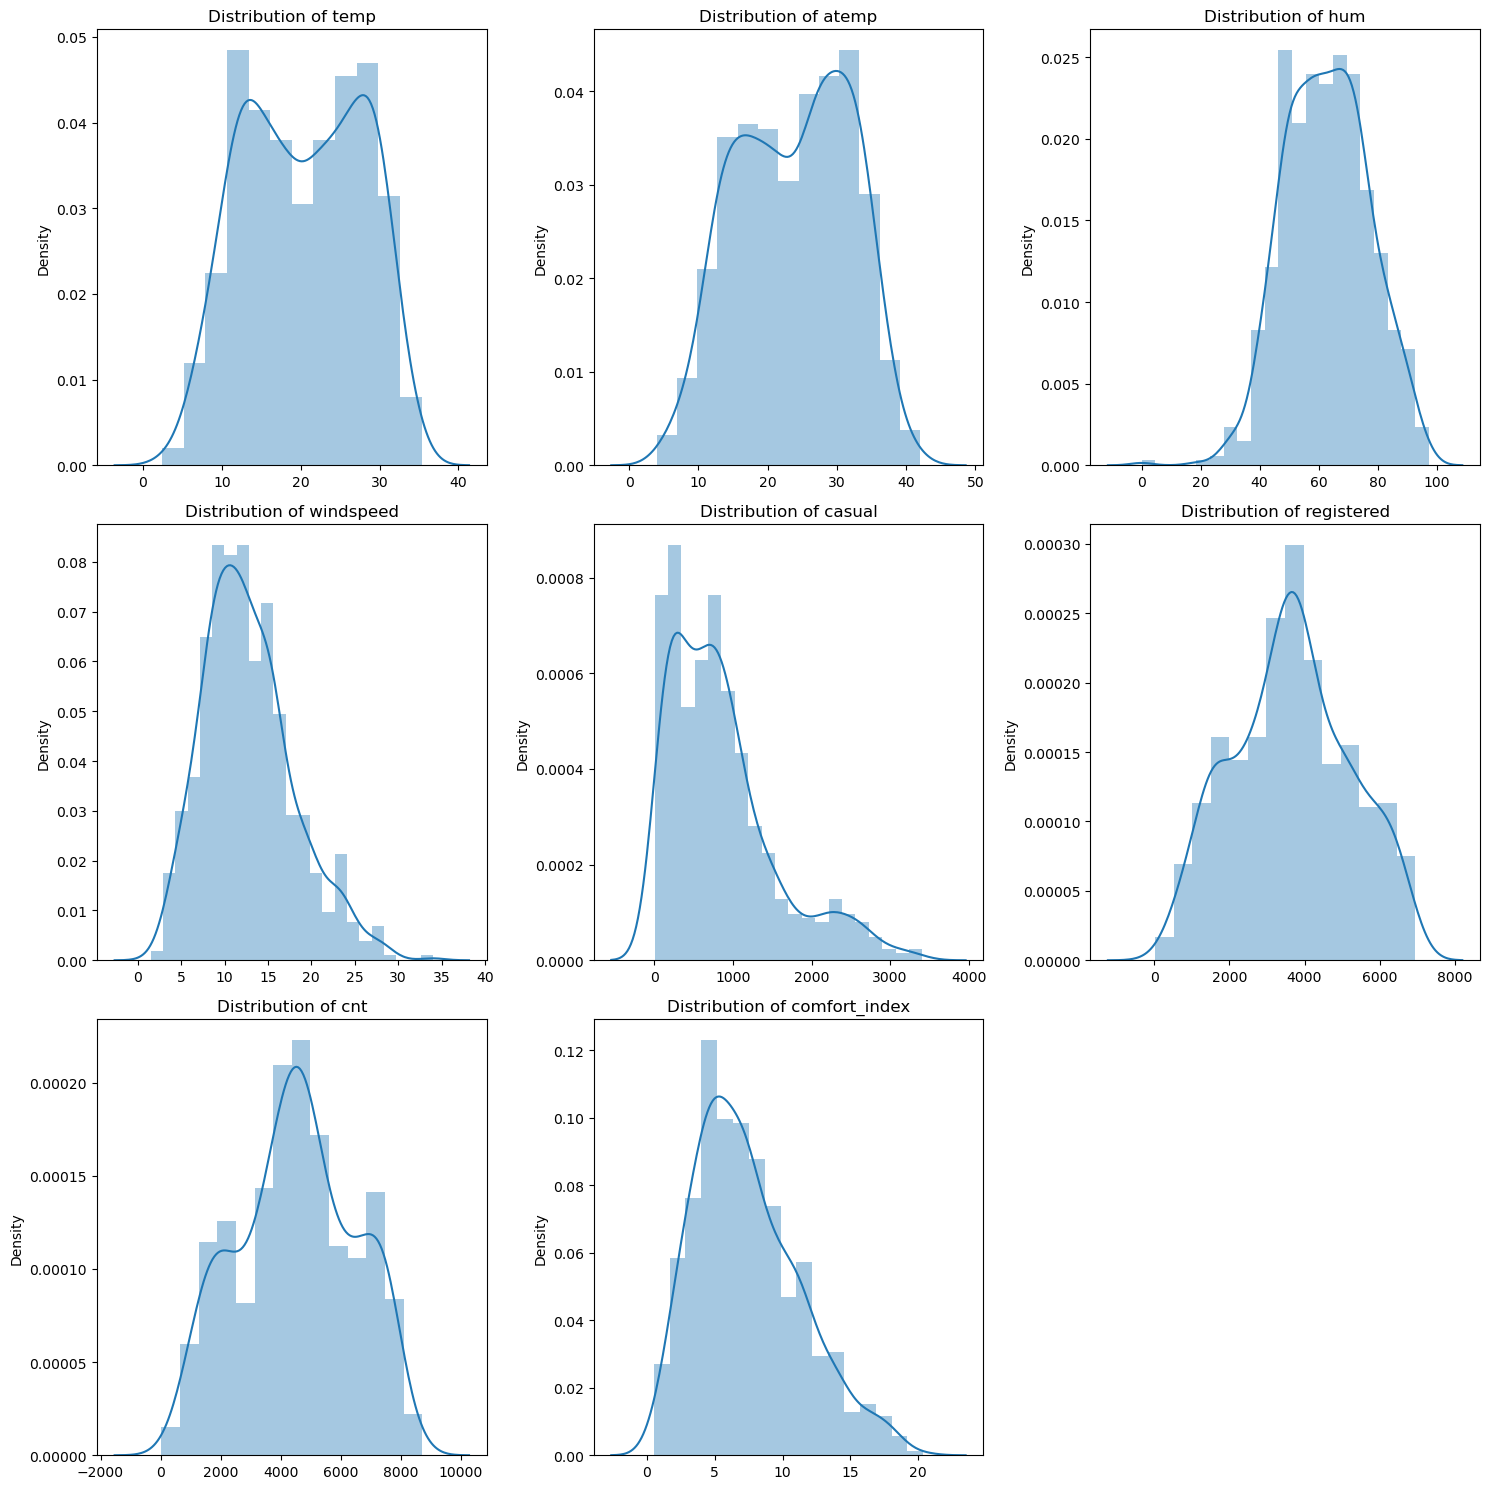

In [4651]:
# Univariate Analysis
# Creating plots to understand the distribution of data and visualize the data for numerical cloumns
def plot_numerical_columns(df, numerical_columns):
    plt.figure(figsize=(15, 15))
    for i, column in enumerate(numerical_columns, 1):
        plt.subplot(3, 3, i)
        sns.distplot(x=df[column])
        plt.title(f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

plot_numerical_columns(df, num_cols)

Observations - 

- temp  - The distribution of temperature appears with roughly two peaks around 13 and 27.
          The data spreads from 0 to around 40, but the bulk of the values lie between 10 and 30.
- atemp - The values range from approximately 0 to 50, with most values between 15 and 35.
- hum   - The values mostly range from 20 to 100, with the highest density between 45 and 85, indicating that humidity is usually within this range.
- windspeed - The data is skewed slightly to the right, with most values between 5 and 20 and fewer values above 20.Higher windspeeds are unusual
- casual - This distribution is highly skewed to the right, indicating that the data might have some extreme values or outliers.
- registered - This distribution seems normal distribution with values spread mostly between 1000 and 7000
- cnt    - This distribution seems normal distribution with values spread mostly between 500 and 8000
- confort_index - This distribution seems normal distribution . It is derived using temperature, humidity

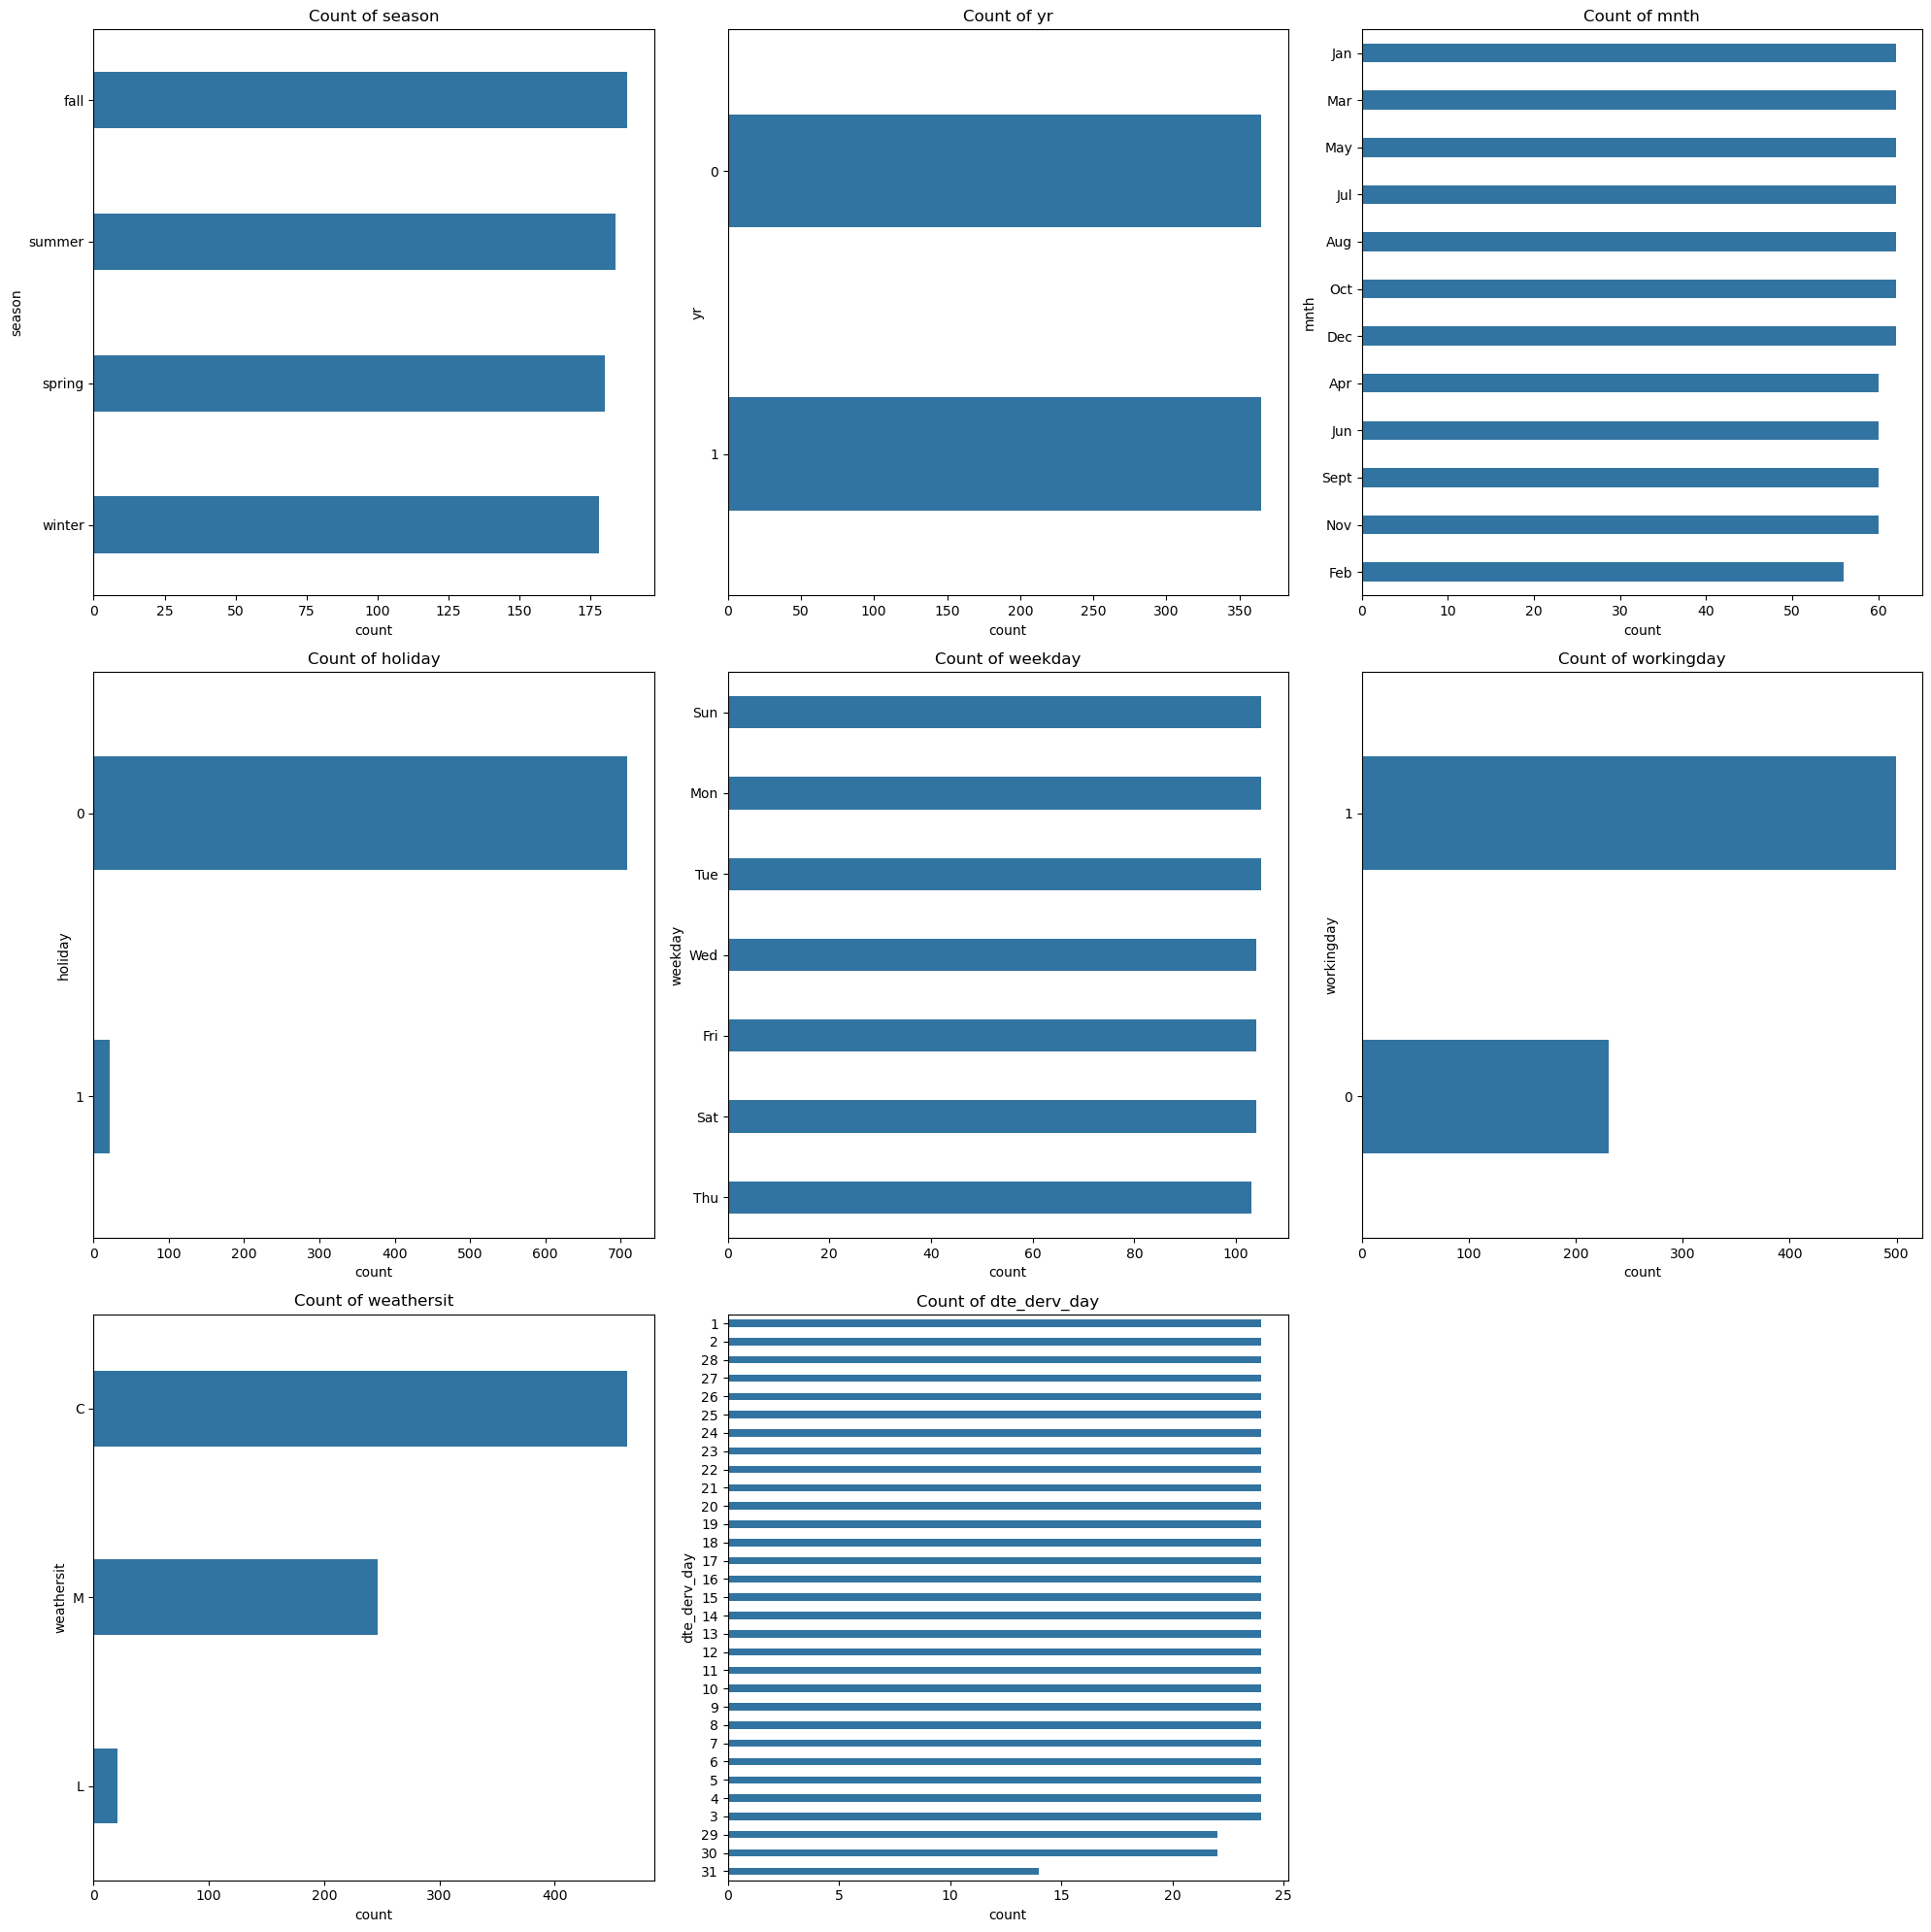

In [4653]:
# Create count plots to understand the distribution of data and visualize the data for categorical columns
def plot_categorical_columns(df, categorical_columns):
    plt.figure(figsize=(20, 20))
    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(3, 3, i)
        sns.countplot(y=df[column].dropna(), order=df[column].value_counts().index, width = 0.4)
        plt.title(f'Count of {column}')
    plt.tight_layout()
    plt.show()

# Plotting the categorical columns
plot_categorical_columns(df, cat_cols)



Observations - 

- season -- All 4 seasons have similar count with fall and summer have slightly more than winter and spring
- year   -- Both the years 2018 & 2019  have similar counts
- months -  Jan, Mar, May, July, August, October, December have similar counts.
          -  Apr, Jun, Sep, Nov have similar counts 
          -  Feb has lesser counts
- holiday - holiday : 1 have very lesser bike rentals than NonHoliday - 0
- weekday - Almost all the days have sinmilar count
- workingday : if day is neither weekend nor holiday is 1 else otherwise is 0 i.e Working day is - 1  Weekend or Holiday - 0
-  Clear, Few clouds, Partly cloudy, Partly cloudy
- weathersit   - C- 1: Clear, Few clouds, Partly cloudy, Partly cloudy   - [More bike rentals than any type]     
		       - M- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist -  [Less count than C but more than other counts] 
		       - L- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds - Very few Records
		       - H- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   - No Records at all
               Most of the records are there in C & M only.
- Derived Day - Derived Column - Date in the month - Almost all days have similar counts and end of the month 29,30,31 have lesser counts.
holiday and workingday are similar in nature.

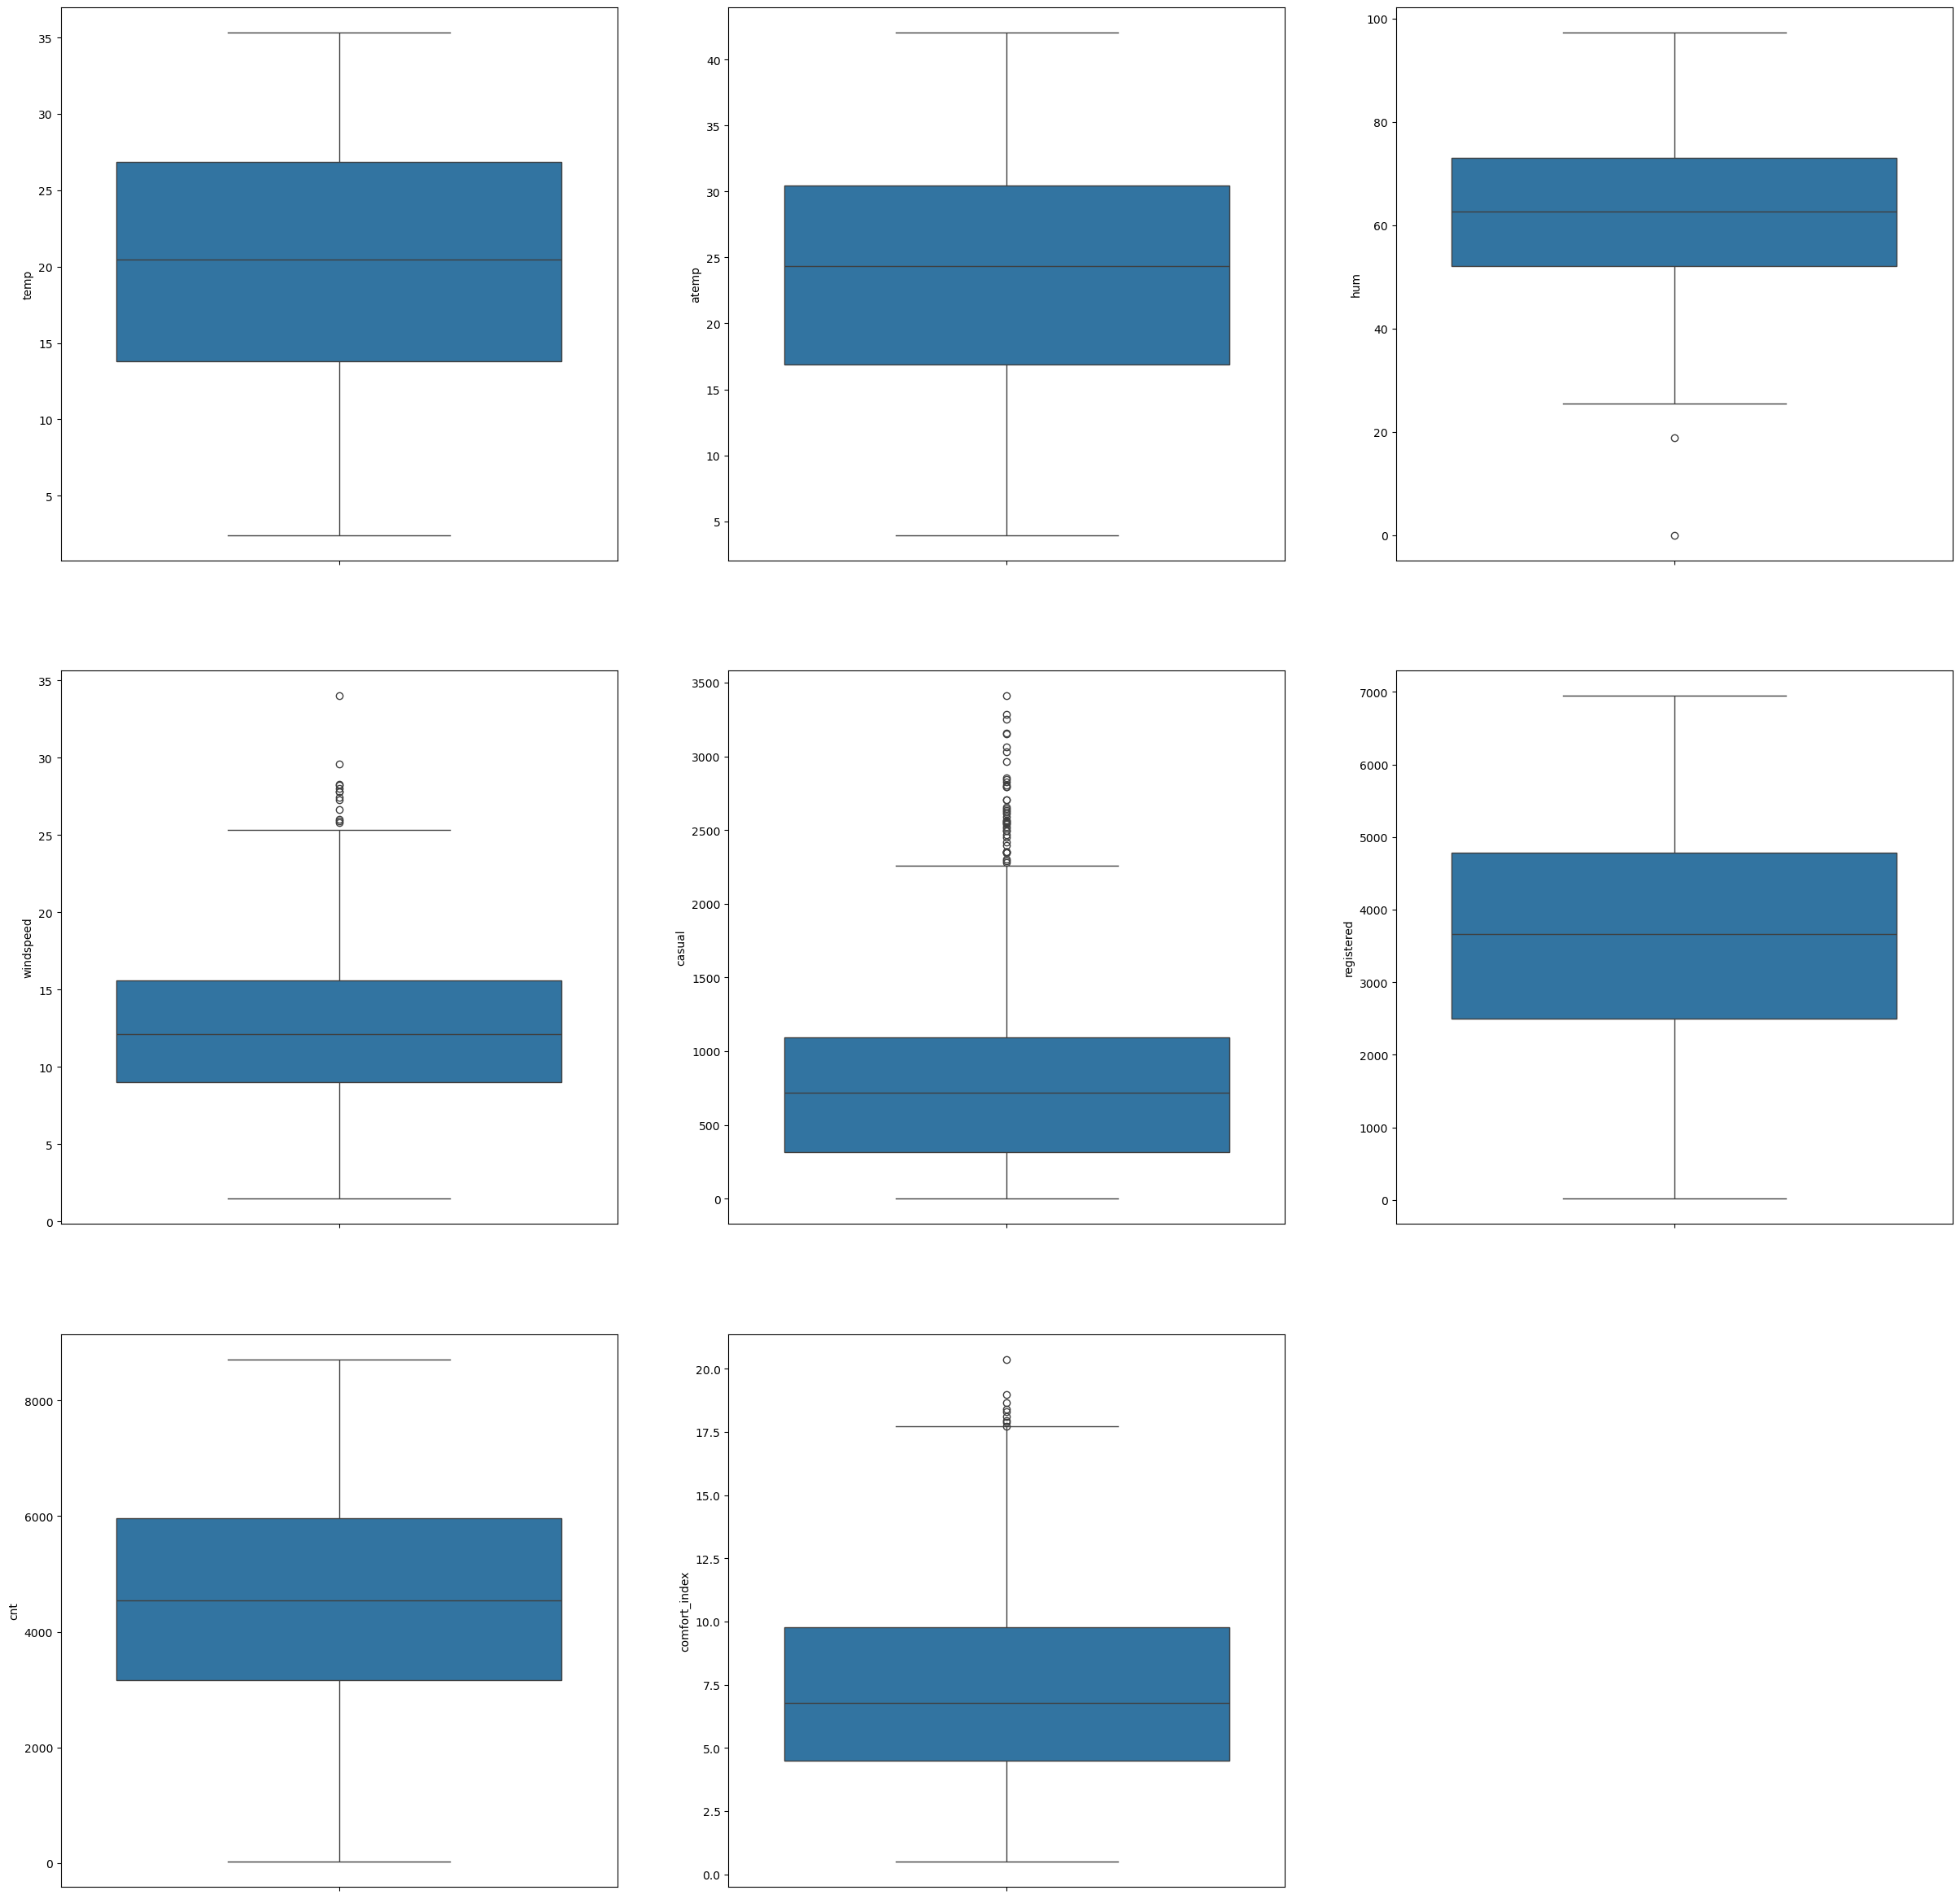

In [4655]:
plt.figure(figsize=(30, 30))
for index, value in enumerate(num_cols):
    plt.subplot(3,3,index + 1)
    sns.boxplot(y = value, data = df)
plt.show()

Outliers Removal

In [4657]:
## It seems there are some outliers for windspeed, humidity and casual users.
## We will remove outliers only from windspeed as humdity has very less outliers and cnt does not have any outliers and hence ignore casual.

col_for_ana_outlier_removal = ['windspeed']

print("Before Outlier Removal ", df.shape)
for c in col_for_ana_outlier_removal:
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Find outliers
    tf = df[(df[c] < lower_bound) | (df[c] > upper_bound)]
    print("Removed Rows for ", c, tf.shape[0])
    df = df[(df[c] >= lower_bound) & (df[c] <= upper_bound)]

print("After Outlier Removal ", df.shape)

Before Outlier Removal  (730, 16)
Removed Rows for  windspeed 13
After Outlier Removal  (717, 16)


### Bivariate Analysis

<Figure size 1500x1000 with 0 Axes>

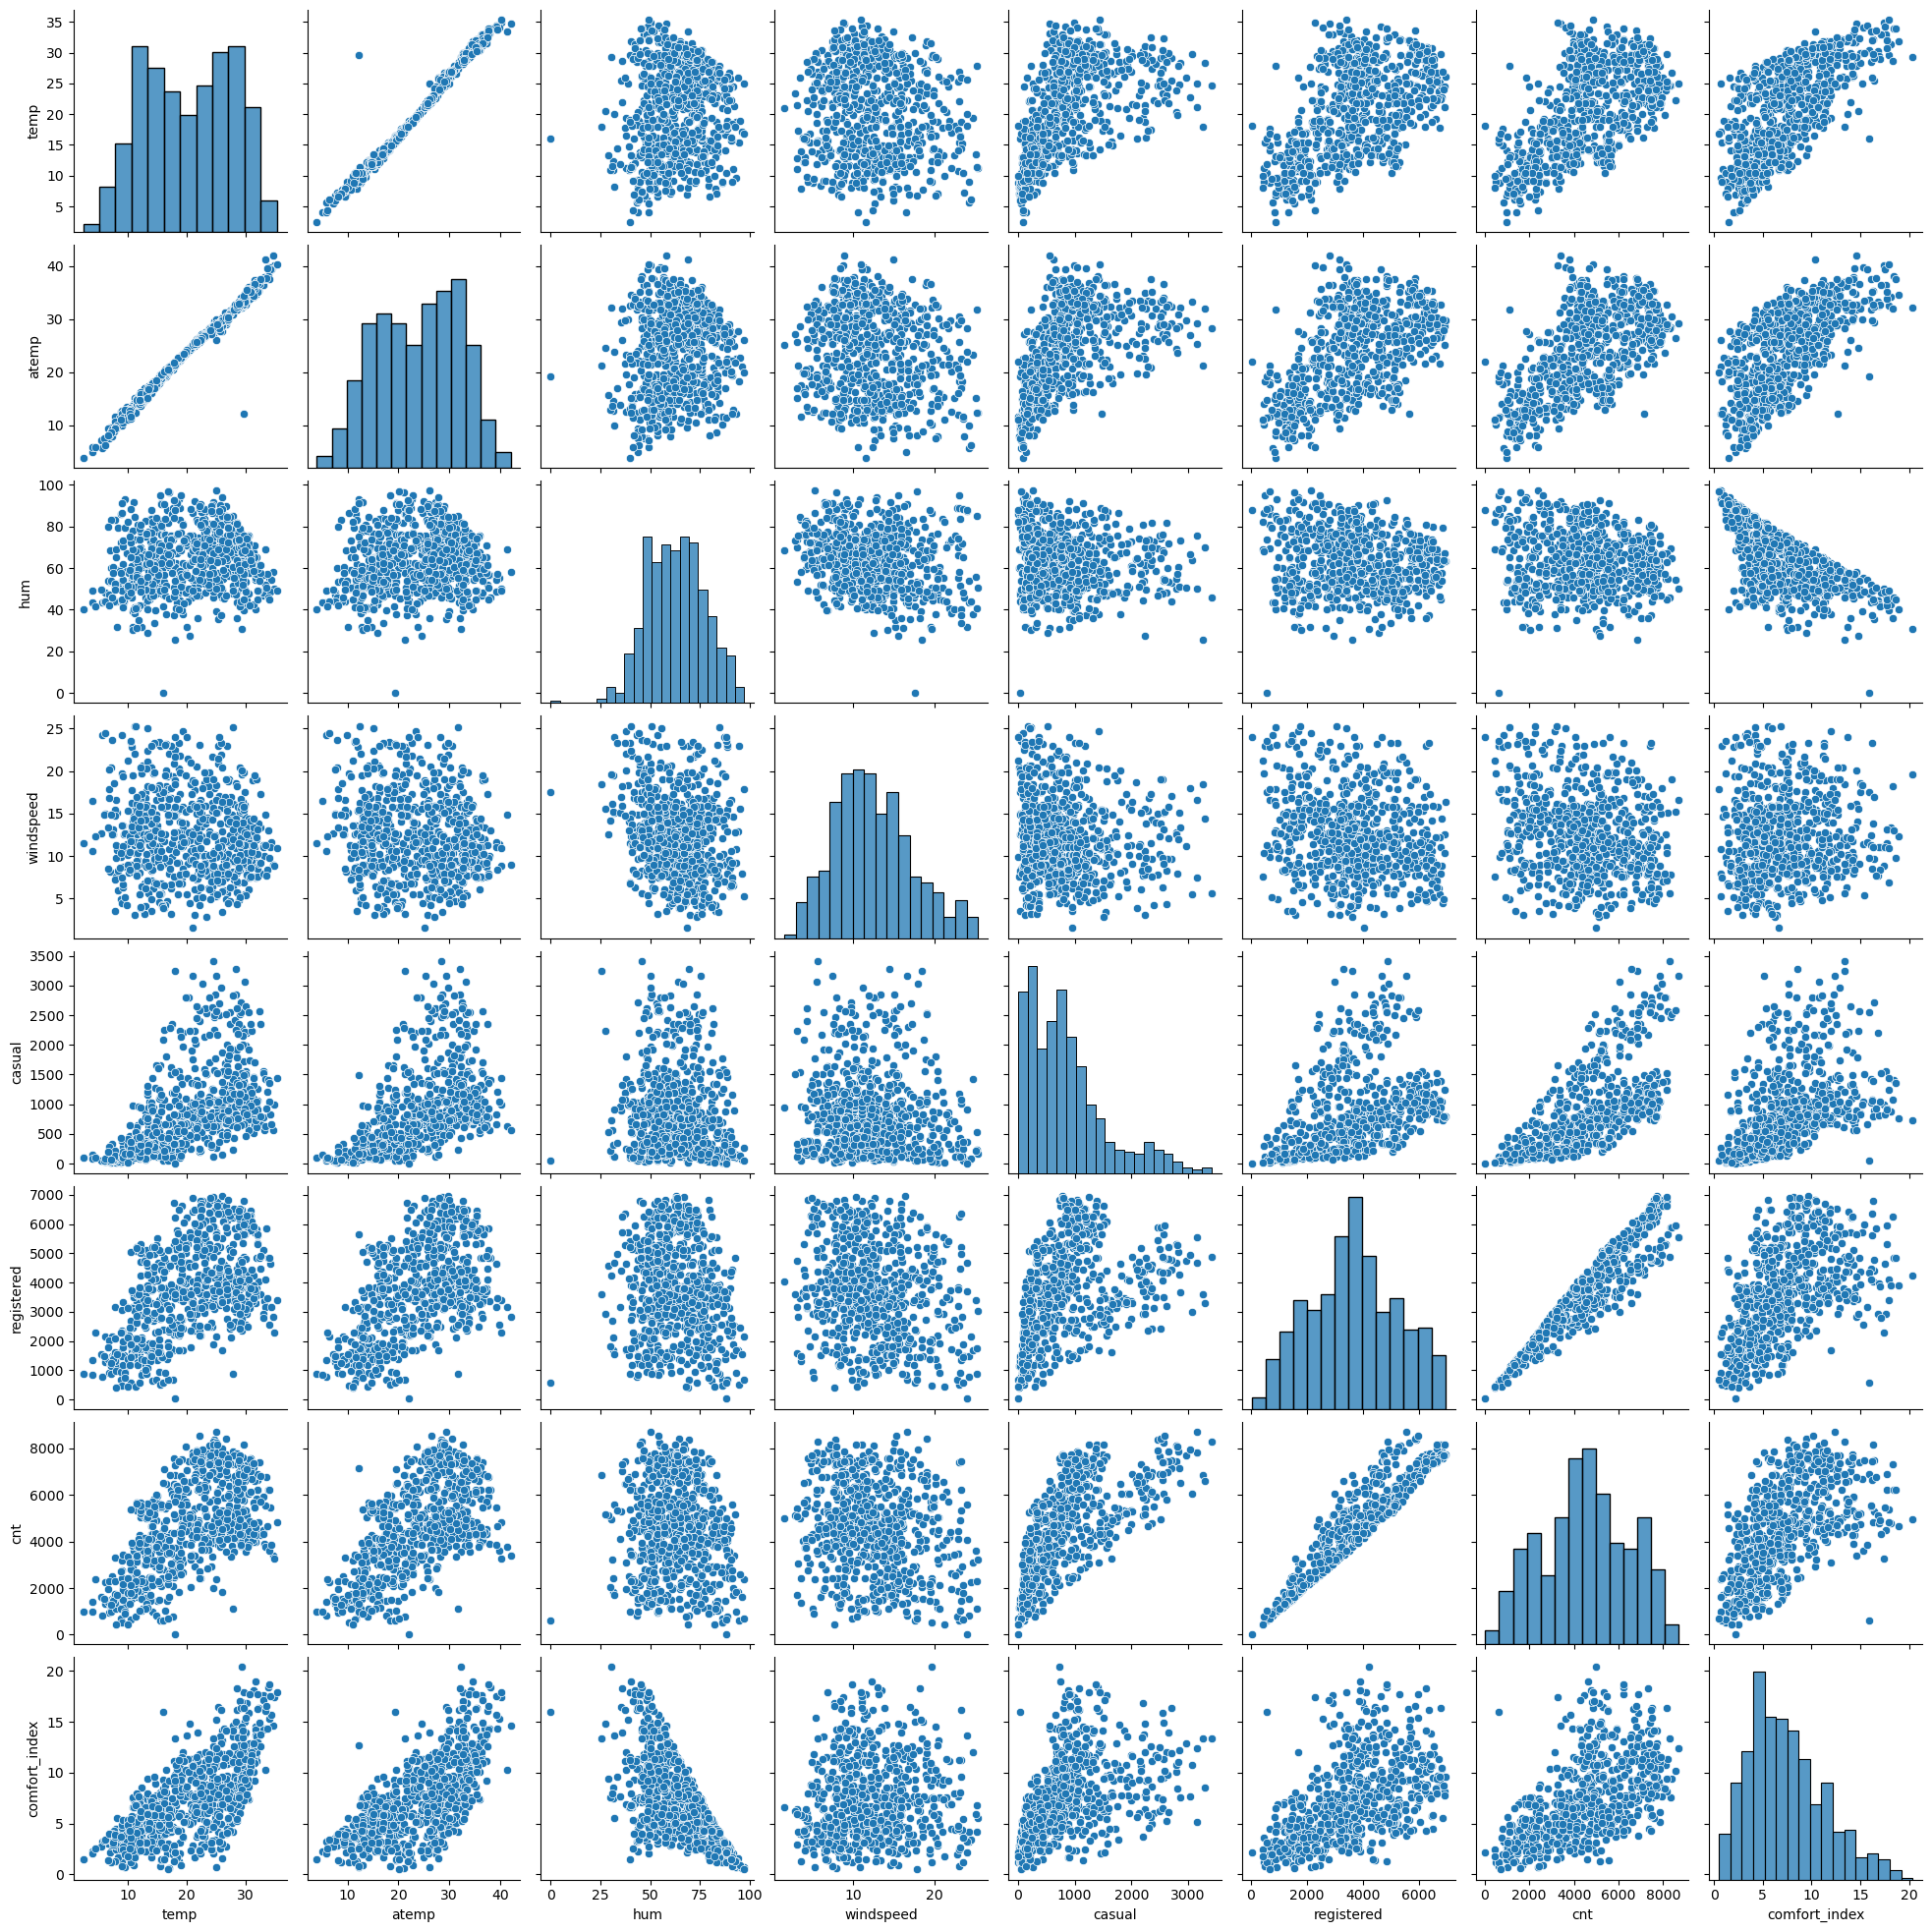

In [4659]:
plt.figure(figsize=(15, 10))
# Bivariate Analysis . Compare cnt column with others
sns.pairplot(df[num_cols])
plt.show()

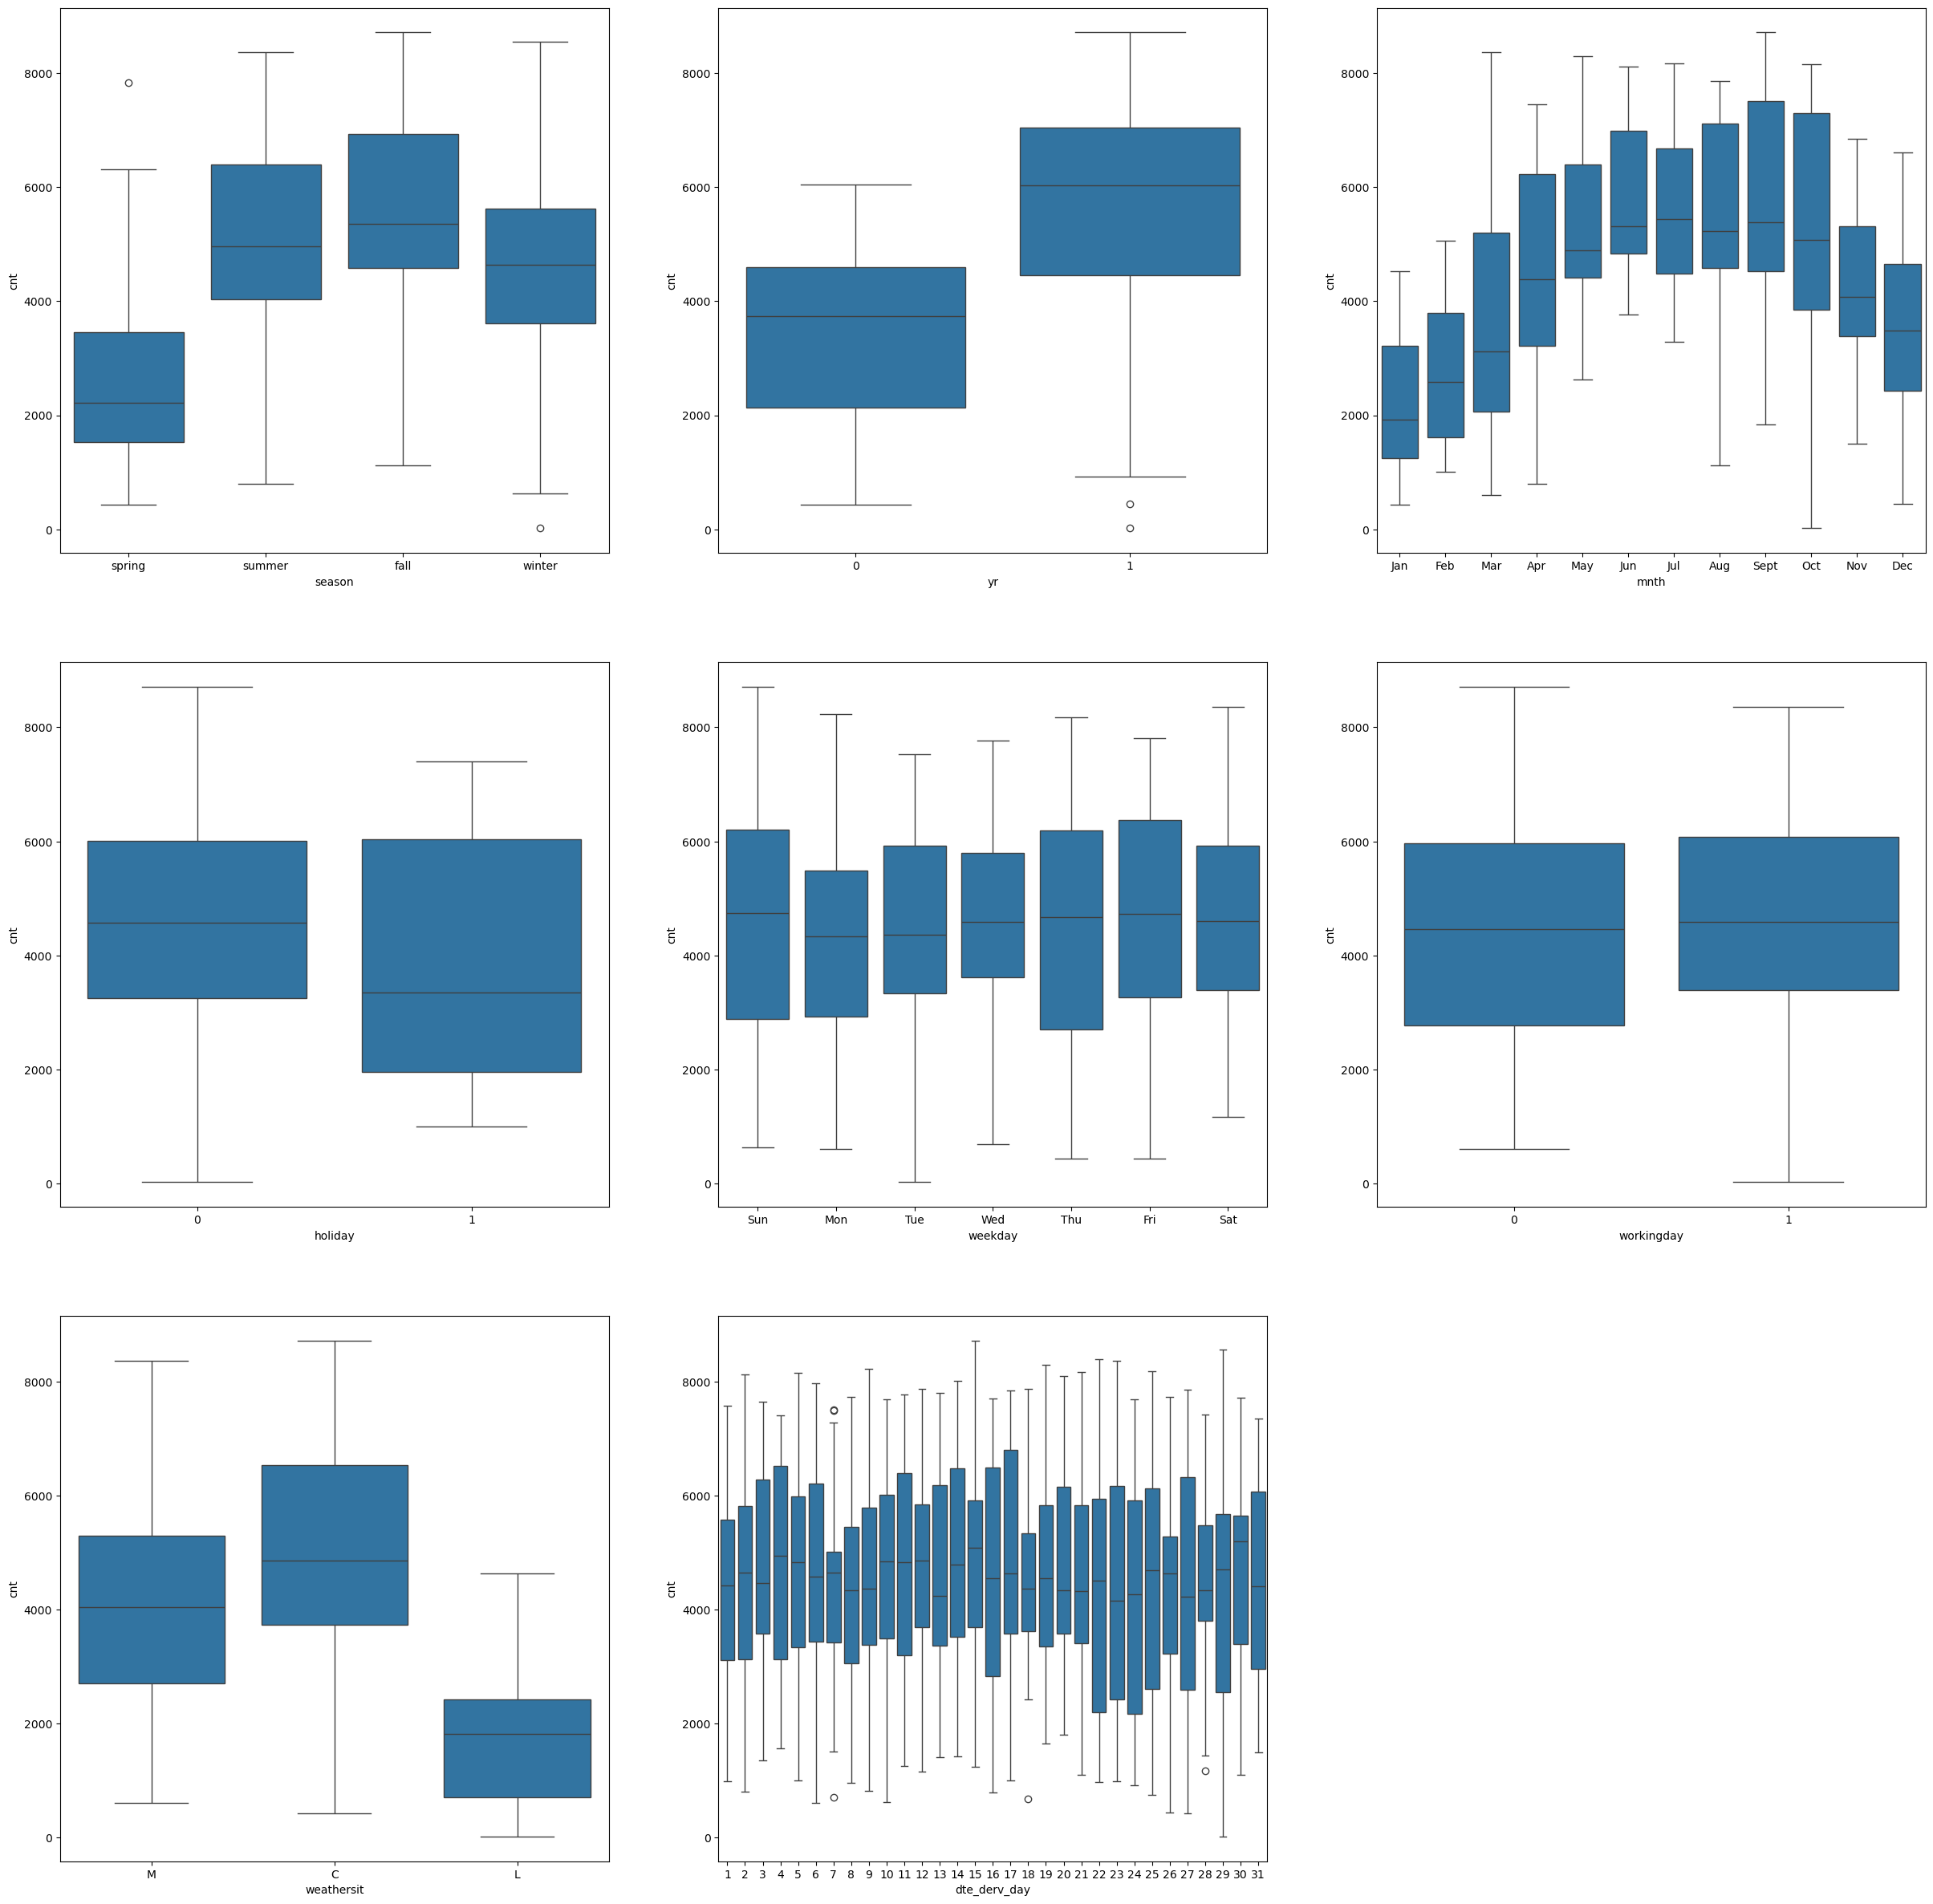

In [4660]:
plt.figure(figsize=(30, 30))
for index, value in enumerate(cat_cols):
    plt.subplot(3,3,index + 1)
    sns.boxplot(x = value, y = 'cnt', data = df)
plt.show()

Bike rentals 
- The average bike rentals are more in fall, followed by summer, winter and spring.
- There are more bike rentals in the year 2019 than in 2018.
- The medium rentals have marginally increased from January to July followed by marginal decrease till December
- The rentals are less on holidays then on normal days.
- The medium rentals are almost same on all the days.
- There are no rentals during Rain or Thunderstorms (4) and more rentals in 1 (Clear & Few Clouds) followed by 2 (Mist & Cloudy) and fewer rentals for - 3 (Light Snow)

### Multivariate Analysis

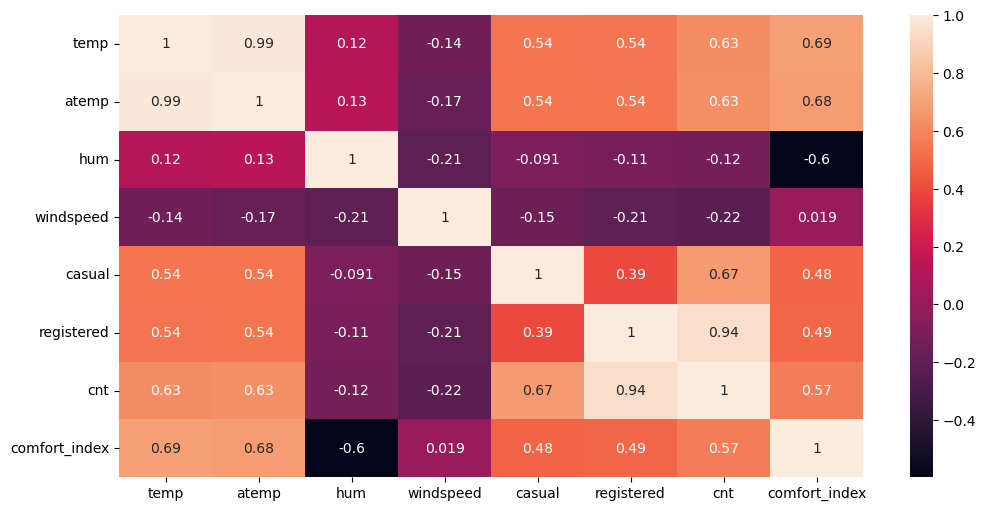

In [4663]:
# Multivariate Analysis
plt.figure(figsize=(12,6))
sns.heatmap(df[num_cols].corr(),annot=True)
plt.show()

### Dropping columns which are not needed

In [4665]:
# Dropping temp column as atemp and temp have high correlation with each other and similar correlation with cnt. 
# Keeping feels like temperature column as it is more relevant to consider feels like as bike riding is outdoor activity an atemp has wind factor in it.
df = df.drop("temp", axis = 1)

# Since cnt is directly derived as the sum of registered and casual, running a regression with these two as independent variables against cnt 
# wouldn’t be very useful. Hence dropping both of the variables.
df = df.drop(["casual", "registered"], axis = 1)
num_cols  = df.select_dtypes(include=['int64', 'float64']).columns.to_numpy()

num_cols

array(['atemp', 'hum', 'windspeed', 'cnt', 'comfort_index'], dtype=object)

In [4666]:
# To see what variables are remaining and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 717 entries, 0 to 729
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   season         717 non-null    object  
 1   yr             717 non-null    category
 2   mnth           717 non-null    object  
 3   holiday        717 non-null    category
 4   weekday        717 non-null    object  
 5   workingday     717 non-null    category
 6   weathersit     717 non-null    object  
 7   atemp          717 non-null    float64 
 8   hum            717 non-null    float64 
 9   windspeed      717 non-null    float64 
 10  cnt            717 non-null    int64   
 11  dte_derv_day   717 non-null    category
 12  comfort_index  717 non-null    float64 
dtypes: category(4), float64(4), int64(1), object(4)
memory usage: 60.5+ KB


Pre-processing Steps

Dummy Variable Creation (One Hot Encoding)

In [4668]:
print("cat columns Remianing ", cat_cols)

cat columns Remianing  Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'dte_derv_day'],
      dtype='object')


In [4669]:
# Number of dummies = n-1
df_with_dummies = pd.get_dummies(df,columns= cat_cols, drop_first=True, dtype=int)


In [4670]:
df_with_dummies.shape

(717, 60)

In [4671]:
df_with_dummies.columns

Index(['atemp', 'hum', 'windspeed', 'cnt', 'comfort_index', 'season_spring',
       'season_summer', 'season_winter', 'yr_1', 'mnth_Aug', 'mnth_Dec',
       'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar', 'mnth_May',
       'mnth_Nov', 'mnth_Oct', 'mnth_Sept', 'holiday_1', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue',
       'weekday_Wed', 'workingday_1', 'weathersit_L', 'weathersit_M',
       'dte_derv_day_2', 'dte_derv_day_3', 'dte_derv_day_4', 'dte_derv_day_5',
       'dte_derv_day_6', 'dte_derv_day_7', 'dte_derv_day_8', 'dte_derv_day_9',
       'dte_derv_day_10', 'dte_derv_day_11', 'dte_derv_day_12',
       'dte_derv_day_13', 'dte_derv_day_14', 'dte_derv_day_15',
       'dte_derv_day_16', 'dte_derv_day_17', 'dte_derv_day_18',
       'dte_derv_day_19', 'dte_derv_day_20', 'dte_derv_day_21',
       'dte_derv_day_22', 'dte_derv_day_23', 'dte_derv_day_24',
       'dte_derv_day_25', 'dte_derv_day_26', 'dte_derv_day_27',
       'dte_derv_day

In [4672]:
df_with_dummies.head(2)

,atemp,hum,windspeed,cnt,comfort_index,season_spring,season_summer,season_winter,yr_1,mnth_Aug,...,dte_derv_day_22,dte_derv_day_23,dte_derv_day_24,dte_derv_day_25,dte_derv_day_26,dte_derv_day_27,dte_derv_day_28,dte_derv_day_29,dte_derv_day_30,dte_derv_day_31
0,18.18125,80.5833,10.749882,985,2.739861,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17.68695,69.6087,16.652113,801,4.529093,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Test Split

In [4674]:
# cnt as the target variable and hence y will be cnt
X = df_with_dummies.drop(["cnt"],axis=1)
y = df_with_dummies["cnt"]


In [4675]:
X.columns

Index(['atemp', 'hum', 'windspeed', 'comfort_index', 'season_spring',
       'season_summer', 'season_winter', 'yr_1', 'mnth_Aug', 'mnth_Dec',
       'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar', 'mnth_May',
       'mnth_Nov', 'mnth_Oct', 'mnth_Sept', 'holiday_1', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 'weekday_Tue',
       'weekday_Wed', 'workingday_1', 'weathersit_L', 'weathersit_M',
       'dte_derv_day_2', 'dte_derv_day_3', 'dte_derv_day_4', 'dte_derv_day_5',
       'dte_derv_day_6', 'dte_derv_day_7', 'dte_derv_day_8', 'dte_derv_day_9',
       'dte_derv_day_10', 'dte_derv_day_11', 'dte_derv_day_12',
       'dte_derv_day_13', 'dte_derv_day_14', 'dte_derv_day_15',
       'dte_derv_day_16', 'dte_derv_day_17', 'dte_derv_day_18',
       'dte_derv_day_19', 'dte_derv_day_20', 'dte_derv_day_21',
       'dte_derv_day_22', 'dte_derv_day_23', 'dte_derv_day_24',
       'dte_derv_day_25', 'dte_derv_day_26', 'dte_derv_day_27',
       'dte_derv_day_28', '

In [4676]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [4677]:
print(X_train.shape)
print(X_test.shape)

(501, 59)
(216, 59)


In [4678]:
# Reset indexes after train and test data to make sure prediction is clean
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4679]:
df_with_dummies.head()

,atemp,hum,windspeed,cnt,comfort_index,season_spring,season_summer,season_winter,yr_1,mnth_Aug,...,dte_derv_day_22,dte_derv_day_23,dte_derv_day_24,dte_derv_day_25,dte_derv_day_26,dte_derv_day_27,dte_derv_day_28,dte_derv_day_29,dte_derv_day_30,dte_derv_day_31
0,18.18125,80.5833,10.749882,985,2.739861,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17.68695,69.6087,16.652113,801,4.529093,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.47025,43.7273,16.636703,1349,4.530472,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10.60610,59.0435,10.739832,1562,3.358433,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.46350,43.6957,12.522300,1600,5.239249,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Scaling

In [4681]:
## Using Standard Scaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
# Train Data 
X_train = scaler.fit_transform(X_train)

# Test Data - As test data is unseen data we can't fit on it
X_test = scaler.transform(X_test)

In [4682]:
# Train Data and Test Data after Scaling
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Test Data
X_test_df = pd.DataFrame(X_test, columns=X.columns)

In [4683]:
X_train_df.head(2)

,atemp,hum,windspeed,comfort_index,season_spring,season_summer,season_winter,yr_1,mnth_Aug,mnth_Dec,...,dte_derv_day_22,dte_derv_day_23,dte_derv_day_24,dte_derv_day_25,dte_derv_day_26,dte_derv_day_27,dte_derv_day_28,dte_derv_day_29,dte_derv_day_30,dte_derv_day_31
0,1.127391,-0.910197,1.599035,1.906770,-0.564288,-0.564288,-0.573509,0.990069,-0.31414,-0.31029,...,-0.198542,-0.181631,-0.203912,5.505679,-0.187414,-0.193047,-0.193047,-0.175682,-0.181631,-0.142712
1,0.759761,0.668779,1.958349,-0.056274,-0.564288,1.772144,-0.573509,-1.010030,-0.31414,-0.31029,...,-0.198542,-0.181631,-0.203912,-0.181631,5.335784,-0.193047,-0.193047,-0.175682,-0.181631,-0.142712


### Feature Selection

In [4685]:
# We have lot of features and selecting 11 features using RFE
features_count = 11
# As there are lot of features we are doing RFE to filter most of the features
estimator = LinearRegression()
selector1 = RFE(estimator, n_features_to_select=features_count)
selector1 = selector1.fit(X_train_df, y_train)

In [4686]:
#Columns selected by RFE and their weights
list(zip(X_train_df.columns,selector1.support_,selector1.ranking_))

[('atemp', True, 1),
 ('hum', False, 30),
 ('windspeed', True, 1),
 ('comfort_index', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 14),
 ('season_winter', True, 1),
 ('yr_1', True, 1),
 ('mnth_Aug', False, 15),
 ('mnth_Dec', False, 2),
 ('mnth_Feb', False, 7),
 ('mnth_Jan', False, 3),
 ('mnth_Jul', False, 46),
 ('mnth_Jun', False, 39),
 ('mnth_Mar', False, 40),
 ('mnth_May', True, 1),
 ('mnth_Nov', True, 1),
 ('mnth_Oct', False, 35),
 ('mnth_Sept', True, 1),
 ('holiday_1', False, 4),
 ('weekday_Mon', False, 5),
 ('weekday_Sat', False, 47),
 ('weekday_Sun', False, 12),
 ('weekday_Thu', False, 49),
 ('weekday_Tue', False, 38),
 ('weekday_Wed', False, 37),
 ('workingday_1', False, 13),
 ('weathersit_L', True, 1),
 ('weathersit_M', True, 1),
 ('dte_derv_day_2', False, 36),
 ('dte_derv_day_3', False, 20),
 ('dte_derv_day_4', False, 11),
 ('dte_derv_day_5', False, 26),
 ('dte_derv_day_6', False, 19),
 ('dte_derv_day_7', False, 23),
 ('dte_derv_day_8', False, 42),
 ('dte_d

In [4687]:
# Selected features based on ranking
selected1_features = X_train_df.columns[selector1.support_]
print(selected1_features)

Index(['atemp', 'windspeed', 'comfort_index', 'season_spring', 'season_winter',
       'yr_1', 'mnth_May', 'mnth_Nov', 'mnth_Sept', 'weathersit_L',
       'weathersit_M'],
      dtype='object')


In [4688]:
# Train Data and Test Data after features are selected
X_train_rfe = X_train_df[selected1_features]

# Test Data
X_test_rfe = X_test_df[selected1_features]

## Modelling

In [4690]:
# Adding an Intercept as a constant to train and test data
X_train_sm = sm.add_constant(X_train_rfe)
X_test_sm = sm.add_constant(X_test_rfe)

In [4691]:
# Ordinary Least Squares
model1 = sm.OLS(np.array(y_train),X_train_sm)
model1 = model1.fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     244.3
Date:                Tue, 29 Oct 2024   Prob (F-statistic):          1.08e-190
Time:                        01:07:29   Log-Likelihood:                -4043.3
No. Observations:                 501   AIC:                             8111.
Df Residuals:                     489   BIC:                             8161.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4510.7685     35.002    128.874      0.000    4441.997    4579.540
atemp           607.8529     66.542      9.135      0.000     477.110     738.595
windspeed      -158.3599     37.740     -4.196      0.000    -232.513     -84.206
comfort_index   342.1565     62.235      5.498      0.000     219.875     464.438
season_spring  -414.6217     57.368     -7.227      0.000    -527.339    -301.904
season_winter   311.2700     52.128      5.971      0.000     208.848     413.692
yr_1           1021.1935     35.809     28.518      0.000     950.835    1091.552
mnth_May        147.4478     38.579      3.822      0.000      71.647     223.249
mnth_Nov       -149.9869     42.537     -3.526      0.000    -233.565     -66.409
mnth_Sept       178.1609     37.706      4.725      0.000     104.074     252.247
weathersit_L   -299.9836     38.388     -7.814      0.000    -375.410    -224.557
weathersit_M   -159.3154     42.662     -3.734      0.000    -243.139     -75.492
==============================================================================
Omnibus:                       75.958   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.610
Skew:                          -0.724   Prob(JB):                     3.38e-48
Kurtosis:                       5.894   Cond. No.                         3.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4692]:
## Variation Inflation Factor - To check for Multicollinearity.
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_sm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_sm.values,i) 
                 for i in range(len(X_train_sm.columns))]
vif_data

,Feature,VIF
0,const,1.000000
1,atemp,3.614196
2,windspeed,1.162627
3,comfort_index,3.161561
4,season_spring,2.686324
5,season_winter,2.217993
6,yr_1,1.046683
7,mnth_May,1.214865
8,mnth_Nov,1.476932
9,mnth_Sept,1.160525


In [4693]:
# Acceptable Range for p-values is < 0.05
# Acceptable Range for VIF is <= 5
# With 11 features we had R-squared: 0.846 and no features with p-values more than 0.05 and VIF >= 5
# So we try to reduce features to 10 and try the model to see if there is any larger impact

In [4694]:
## Manual Feature Selection

In [4695]:
# Removing comfort_index as it based on temp and windspeed and atemp considers temp with chill factor, humidity and radiation
X_train2_rfe = X_train_rfe.drop("comfort_index",axis=1)
X_train2_sm = X_train_sm.drop("comfort_index",axis=1)
X_test2_sm = X_test_sm.drop("comfort_index",axis=1)

In [4696]:
model2 = sm.OLS(np.array(y_train),X_train2_sm)# Ordinary Least Squares
model2 = model2.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     250.8
Date:                Tue, 29 Oct 2024   Prob (F-statistic):          1.48e-185
Time:                        01:07:29   Log-Likelihood:                -4058.4
No. Observations:                 501   AIC:                             8139.
Df Residuals:                     490   BIC:                             8185.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4510.7685     36.030    125.194      0.000    4439.976    4581.561
atemp           806.4964     57.520     14.021      0.000     693.481     919.512
windspeed      -116.9723     38.069     -3.073      0.002    -191.771     -42.174
season_spring  -452.4466     58.627     -7.717      0.000    -567.639    -337.255
season_winter   257.8950     52.721      4.892      0.000     154.309     361.482
yr_1           1046.7044     36.551     28.637      0.000     974.889    1118.520
mnth_May         94.7475     38.467      2.463      0.014      19.166     170.329
mnth_Nov       -154.0603     43.781     -3.519      0.000    -240.081     -68.040
mnth_Sept       129.6657     37.737      3.436      0.001      55.518     203.813
weathersit_L   -373.3793     37.050    -10.078      0.000    -446.176    -300.583
weathersit_M   -285.3044     37.042     -7.702      0.000    -358.086    -212.523
==============================================================================
Omnibus:                       67.667   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.641
Skew:                          -0.680   Prob(JB):                     1.19e-38
Kurtosis:                       5.553   Cond. No.                         3.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4697]:
## Variation Inflation Factor - To check for Multicollinearity.
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train2_sm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train2_sm.values,i) 
                 for i in range(len(X_train2_sm.columns))]
vif_data

,Feature,VIF
0,const,1.000000
1,atemp,2.548580
2,windspeed,1.116368
3,season_spring,2.647687
4,season_winter,2.141057
5,yr_1,1.029108
6,mnth_May,1.139862
7,mnth_Nov,1.476484
8,mnth_Sept,1.097014
9,weathersit_L,1.057408


In [4698]:
## Removing comfort_index did not have any big impact on cnt as R-Square reduced marginally by 0.9 to 83.7

In [4699]:
## As atemp considers temp with chill factor, humidity and radiation, we will try to see if removing windspeed has any impact or not.
X_train3_rfe = X_train2_rfe.drop("windspeed",axis=1)
X_train3_sm = X_train2_sm.drop("windspeed",axis=1)
X_test3_sm = X_test2_sm.drop("windspeed",axis=1)

In [4700]:
model3 = sm.OLS(np.array(y_train),X_train3_sm)# Ordinary Least Squares
model3 = model3.fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     272.9
Date:                Tue, 29 Oct 2024   Prob (F-statistic):          9.19e-185
Time:                        01:07:29   Log-Likelihood:                -4063.1
No. Observations:                 501   AIC:                             8146.
Df Residuals:                     491   BIC:                             8188.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4510.7685     36.339    124.132      0.000    4439.370    4582.167
atemp           841.1877     56.883     14.788      0.000     729.423     952.953
season_spring  -438.1698     58.943     -7.434      0.000    -553.982    -322.358
season_winter   295.5918     51.712      5.716      0.000     193.987     397.196
yr_1           1045.3062     36.861     28.358      0.000     972.882    1117.731
mnth_May         99.3989     38.767      2.564      0.011      23.230     175.568
mnth_Nov       -162.6594     44.065     -3.691      0.000    -249.239     -76.080
mnth_Sept       135.5433     38.012      3.566      0.000      60.858     210.229
weathersit_L   -385.6285     37.150    -10.380      0.000    -458.621    -312.636
weathersit_M   -287.5073     37.352     -7.697      0.000    -360.897    -214.117
==============================================================================
Omnibus:                       66.270   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.199
Skew:                          -0.660   Prob(JB):                     1.49e-38
Kurtosis:                       5.569   Cond. No.                         3.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that the equation of our best fitted line is:

cnt = 4510.7685 + (869.1712 * atemp) − (414.8227 * season_spring) + (220.5369 * season_winter) + (1043.7114 * yr_1) + (101.9642 * mnth_May) 
      + (147.7071 * mnth_Sept) − (381.7904 * weathersit_L)  - (272.3049 * weathersit_M)

Based on final model the below features explain the demand as :

1) yr_1 - Year 2019 (1043.7114) - Rental growth has increased significantly from 2018 to 2019 
2) atemp - Feeling Temperatrure (869.1712) - It has very high impact on the bike rentals as many people tend to rent bikes when the feeling temperature is good and not too cold or too hot.This suggests that people are more likely to rent bikes when the weather feels warmer, which aligns with expected seasonality.
3) Season -
     a) season_spring (-414.8227) - Rentals decrease significantly in the spring probably because of rains.
     b) season_winter (220.5369) - Winter shows a positive impact on rentals.
This could indicate that certain weather factors (like rain in spring) discourage bike usage, while other conditions (like clear, cold winter days) may not impact rentals as negatively as expected.
4) Months -
     a) mnth_Sept (147.7071) - 
     b) mnth_May  (101.9642) - 
Bike rentals increased slightly in May,September probably because of pleasant weather.
5) Weather - 
     a) weathersit_L (-381.7904) - 
	 b) weathersit_M (-272.3049)- 
Weather conditions negatively impact bike rentals, particularly when conditions include mist, clouds, or light rain.

Recommendations
1) Promotions and campaigns should be increased during warmer seasons or favorable weather periods to capitalize on increased demand. Also, forecasting demand based on expected temperature changes could improve bike availability management.
2) Understanding seasonal preferences allows for seasonal marketing adjustments. Discounts can be provided on off-season to generate more bike rentals.
3) The bike rental growth has increased significantly from 2018 to 2019 and if this trend continues, new locations can be added and increasing the no of bikes will increase revenue in future.
4) Different promotional campaigns during the months May and September can be run to add more rentals. The promotional campaign for September should be different than May as Summer is followed after May and September comes in Fall season.
5) Given that bad weather reduces rentals, it could be useful to develop a flexible pricing model, multi-month discount programs that offers discounts on rainy or misty days.

In [4704]:
## Variation Inflation Factor - To check for Multicollinearity.
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train3_sm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train3_sm.values,i) 
                 for i in range(len(X_train3_sm.columns))]
vif_data

,Feature,VIF
0,const,1.000000
1,atemp,2.450387
2,season_spring,2.631056
3,season_winter,2.025113
4,yr_1,1.028948
5,mnth_May,1.138097
6,mnth_Nov,1.470451
7,mnth_Sept,1.094196
8,weathersit_L,1.045166
9,weathersit_M,1.056570


In [4705]:
## Removing windspeed did not have any big impact on cnt as R-Square reduced marginally by 0.4 to 83.3
## Removing mnth_Nov

In [4706]:
X_train4_rfe = X_train3_rfe.drop("mnth_Nov",axis=1)
X_train4_sm = X_train3_sm.drop("mnth_Nov",axis=1)
X_test4_sm = X_test3_sm.drop("mnth_Nov",axis=1)

In [4707]:
model4 = sm.OLS(np.array(y_train),X_train4_sm)# Ordinary Least Squares
model4 = model4.fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     297.7
Date:                Tue, 29 Oct 2024   Prob (F-statistic):          4.19e-183
Time:                        01:07:30   Log-Likelihood:                -4070.0
No. Observations:                 501   AIC:                             8158.
Df Residuals:                     492   BIC:                             8196.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4510.7685     36.802    122.569      0.000    4438.460    4583.077
atemp           869.1712     57.095     15.223      0.000     756.991     981.351
season_spring  -414.8227     59.350     -6.989      0.000    -531.433    -298.212
season_winter   220.5369     48.153      4.580      0.000     125.925     315.149
yr_1           1043.7114     37.328     27.960      0.000     970.369    1117.054
mnth_May        101.9642     39.255      2.598      0.010      24.837     179.092
mnth_Sept       147.7071     38.351      3.851      0.000      72.355     223.060
weathersit_L   -381.7904     37.609    -10.152      0.000    -455.685    -307.896
weathersit_M   -272.3049     37.598     -7.243      0.000    -346.177    -198.433
==============================================================================
Omnibus:                       65.405   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.655
Skew:                          -0.664   Prob(JB):                     1.07e-36
Kurtosis:                       5.484   Cond. No.                         3.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4708]:
## Variation Inflation Factor - To check for Multicollinearity.
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train4_sm.columns

vif_data["VIF"]=[variance_inflation_factor(X_train4_sm.values,i) 
                 for i in range(len(X_train4_sm.columns))]
vif_data

,Feature,VIF
0,const,1.000000
1,atemp,2.406866
2,season_spring,2.600762
3,season_winter,1.712037
4,yr_1,1.028807
5,mnth_May,1.137731
6,mnth_Sept,1.085973
7,weathersit_L,1.044347
8,weathersit_M,1.043726


In [4709]:
## Removing mnth_Nov causes R-Squared to change from 83.3 to 82.9.
## We can proceed with model4  which has 8 features for prediction and R-squared as 82.9 indicating that 82.9% of the variance is explained by model4
## All p-values are < 0.05 and VIF are also < 5

In [4710]:
finalmodel = model4
final_X_train_rfe = X_train4_rfe
final_X_train_sm = X_train4_sm
final_X_test_sm = X_test4_sm

### Model Evaluation

### Residual Analysis

Before we make predictions on the test set, let's first analyse the residuals.

In [4713]:
# Predicting y on the training model based on selected model
y_train_pred  = finalmodel.predict(final_X_train_sm)

In [4714]:
# Calculating Train residual 
res = y_train - y_train_pred

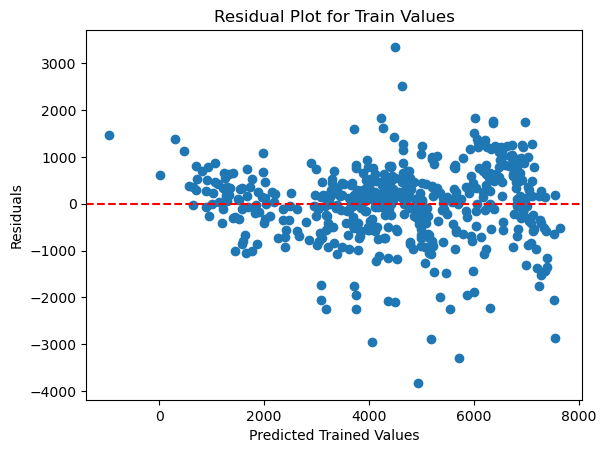

In [4715]:
# Residual Plot for Train Values
plt.scatter(y_train_pred, res)
plt.xlabel('Predicted Trained Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Train Values')
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at y=0
plt.show()

Text(0.5, 0, 'Errors')

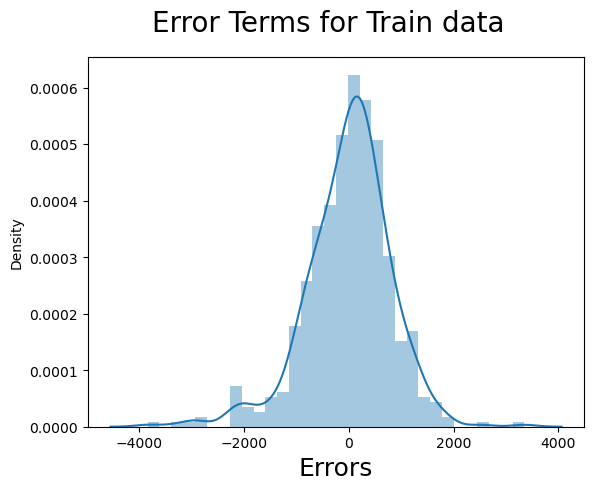

In [4716]:
# Train value Error Terms
# Plot the histogram of the error terms for train values to check for normal distribution of errors
fig = plt.figure()
sns.distplot(res)
# Plot heading
fig.suptitle('Error Terms for Train data', fontsize = 20)    
# Give the X-label
plt.xlabel('Errors', fontsize = 18)     

In [4717]:
# Predicting y on the test model based on selected model
y_test_pred  = finalmodel.predict(final_X_test_sm)

In [4718]:
# Calculating Test residual 
res_test = y_test - y_test_pred

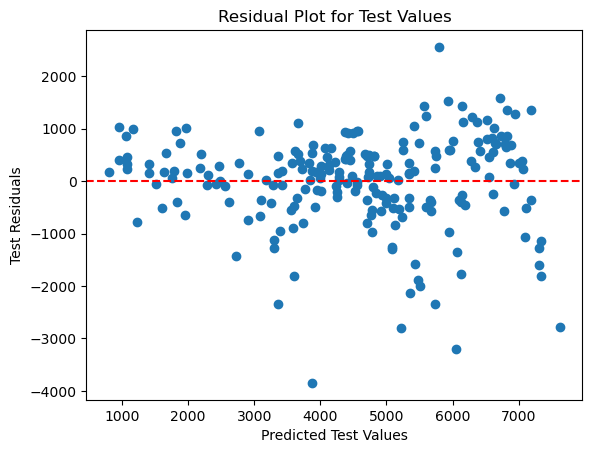

In [4719]:
## Residual Plot for Test
plt.scatter(y_test_pred, res_test)
plt.xlabel('Predicted Test Values')
plt.ylabel('Test Residuals')
plt.title('Residual Plot for Test Values')
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at y=0
plt.show()

Text(0.5, 0, 'Errors')

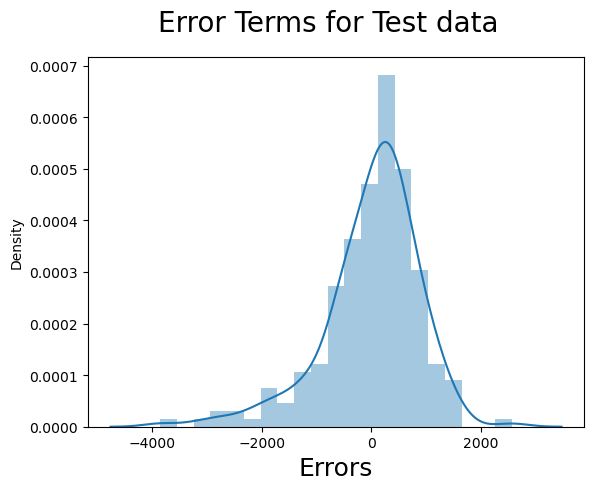

In [4720]:
# Test value Error Terms
# Plot the histogram of the error terms for train values to check for normal distribution of errors
fig = plt.figure()
sns.distplot(res_test)
# Plot heading
fig.suptitle('Error Terms for Test data', fontsize = 20)    
# Give the X-label
plt.xlabel('Errors', fontsize = 18)     

In [4721]:
## We can see from the Residual plot that the points are randomly scattered for both train and test around the horizontal line at zero. 
## This indicates that the residuals are randomly distributed, which is a good sign.

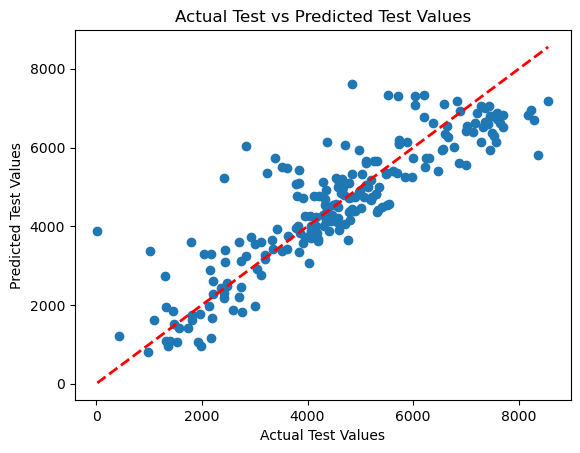

In [4722]:
# Plot actual vs predicted
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Test Values')
plt.ylabel('Predicted Test Values')
plt.title('Actual Test vs Predicted Test Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2) # Diagonal line
plt.show()

Text(0, 0.5, 'Sample Quantiles')

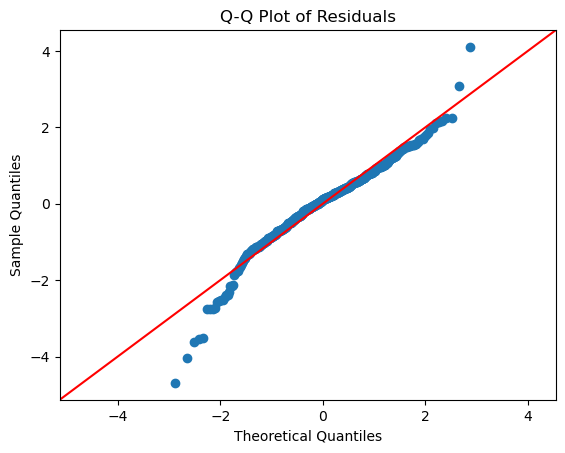

In [4723]:
# Q-Q Plot on residuals
sm.qqplot(res, line = "45",  fit = True)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

In [4724]:
# Durbin-Watson statistic on Test data for testing to check the presence of autocorrelation in the residuals of a regression model.
# Close to 2 indicates 

In [4725]:
dw_stat = durbin_watson(res_test)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 2.166390434444155


In [4726]:
## The above  Q-Q plot of residuals with the line = "45" indicates that the residuals are approximately normally distributed.

In [4727]:
# r2_score for 8 features
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7711005739217855